In [1]:
#https://zhuanlan.zhihu.com/p/31743196
import re
import numpy as np  #載入陣列處理package
import pandas as pd
import matplotlib.pyplot as plt #載入圖表處理Package
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
#載入Package



In [2]:
#載入train和test檔
train_data = pd.read_csv('C:\Anaconda2\Titanic-KaggleTest/train.csv')
test_data = pd.read_csv('C:\Anaconda2\Titanic-KaggleTest/test.csv')


sns.set_style('whitegrid')
train_data.head()
#載入數據

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#叫出train和test資料預覽
train_data.info()
print("-" * 40)
test_data.info()
#看出Age、Cabin、Embarked、Fare的數值不滿891，存在Null值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

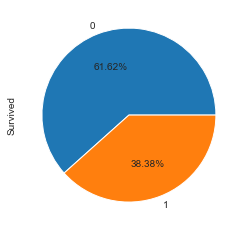

In [4]:
#繪製存活比例圖
train_data['Survived'].value_counts().plot.pie(autopct = '%1.2f%%')

In [5]:
#Embark非重要feature，而且只少兩筆資料，故用眾數補上空值
train_data.Embarked[train_data.Embarked.isnull()] = train_data.Embarked.dropna().mode().values

In [6]:
#for feature Cabin : replace missing value with U0
train_data['Cabin'] = train_data.Cabin.fillna('U0') # train_data.Cabin[train_data.Cabin.isnull()]='U0'

In [7]:
#使用回归 随机森林等模型来预测缺失属性的值。因为Age在该数据集里是一个相当重要的特征（先对Age进行分析即可得知），
#所以保证一定的缺失值填充准确率是非常重要的，对结果也会产生较大影响。
#一般情况下，会使用数据完整的条目作为模型的训练集，以此来预测缺失值。
#对于当前的这个数据，可以使用随机森林来预测也可以使用线性回归预测。
#这里使用随机森林预测模型，选取数据集中的数值属性作为特征（因为sklearn的模型只能处理数值属性，所以这里先仅选取数值特征，
#但在实际的应用中需要将非数值特征转换为数值特征

from sklearn.ensemble import RandomForestRegressor

#choose training data to predict age
age_df = train_data[['Age','Survived','Fare', 'Parch', 'SibSp', 'Pclass']]
age_df_notnull = age_df.loc[(train_data['Age'].notnull())]
age_df_isnull = age_df.loc[(train_data['Age'].isnull())]
X = age_df_notnull.values[:,1:]
Y = age_df_notnull.values[:,0]
# use RandomForestRegression to train data
RFR = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
RFR.fit(X,Y)
predictAges = RFR.predict(age_df_isnull.values[:,1:])
train_data.loc[train_data['Age'].isnull(), ['Age']]= predictAges

In [8]:
#檢視補完缺值後的data資料
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
#進入分析
#1. 性別與生存與否的關係(製表)
train_data.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

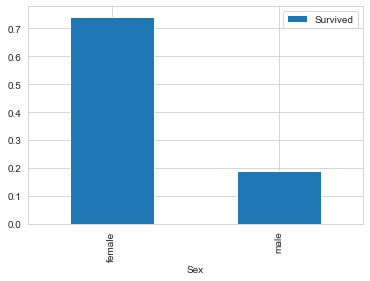

In [10]:
#1. 性別與生存與否的關係(製圖)
train_data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()#以性別分組，匯圖
#可見女性生存比例遠高於男性，推測為lady 1st精神的體現

In [11]:
#2. 艙等與生存與否的關係(製表)
train_data.groupby(['Pclass','Survived'])['Survived'].count()
#為什麼原作這裡用count()用Pclass，不用Survived?

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

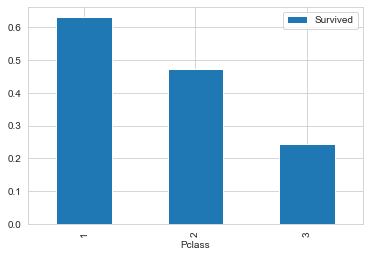

In [12]:
#2. 艙等與生存與否的關係(製圖)
train_data[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar() #以艙等groupby


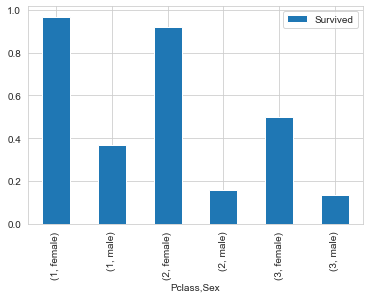

In [13]:
#3. 性別與艙等同時討論
train_data[['Sex','Pclass','Survived']].groupby(['Pclass','Sex']).mean().plot.bar()

In [14]:
#3. 性別與艙等同時討論
train_data.groupby(['Pclass','Sex','Survived'])['Survived'].count()

Pclass  Sex     Survived
1       female  0             3
                1            91
        male    0            77
                1            45
2       female  0             6
                1            70
        male    0            91
                1            17
3       female  0            72
                1            72
        male    0           300
                1            47
Name: Survived, dtype: int64

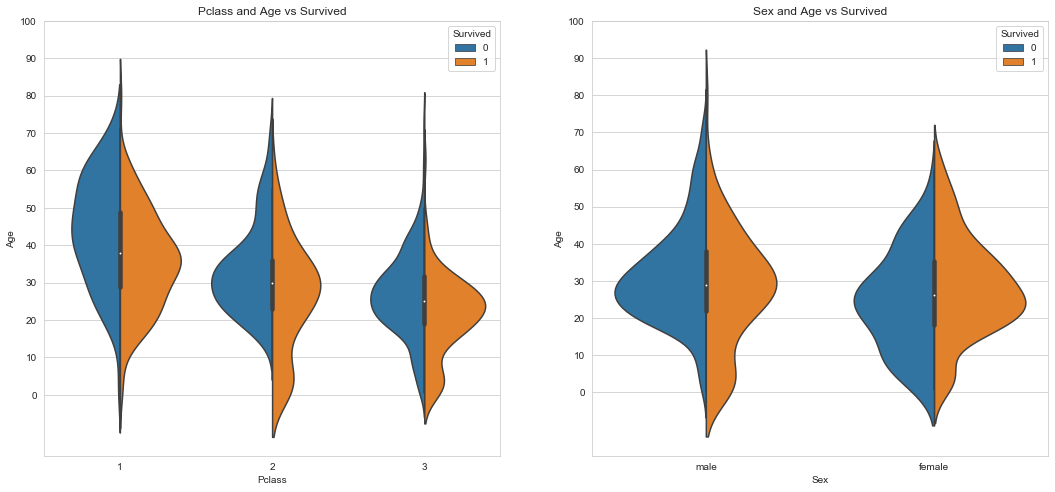

In [15]:
#4. 年齡與存活與否的關係
#4. 分别分析不同等级船舱和不同性别下的年龄分布和生存的关系
#---------------------------------------------------------
# fig, ax= plt.subplots輸出總畫布視窗
#  原指令matpltlib.pyplot.figure(num = None, figsize=None, dpi=None,facecolor=None,edgecolor=None,frameon=True,
#  FigureClass=<class 'matplotlib.figure.Figure'>,clear=False,**kwargs)

fig, ax = plt.subplots(1, 2, figsize = (18, 8))  #畫布上圖表排列1*2，圖表大小18*8
#繪製小提琴圖(x軸, y軸 , hue=小提琴欄 , 表格名稱 , split=true將Survived 0,1繪在宏一小提琴圖中,置於ax[0]即左圖)
#原指令 seaborn.violinplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None, bw=’scott’, cut=2, scale=’area’, 
#scale_hue=True, gridsize=100, width=0.8, inner=’box’, split=False, dodge=True, orient=None, linewidth=None, color=None, 
#palette=None, saturation=0.75, ax=None, **kwargs)
sns.violinplot("Pclass", "Age", hue="Survived", data=train_data, split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))

sns.violinplot("Sex", "Age", hue="Survived", data=train_data, split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))

plt.show()

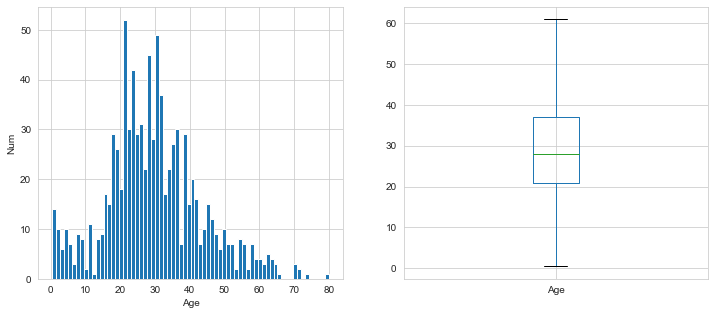

In [16]:
# 分析總體年齡分布
plt.figure(figsize=(12,5))
plt.subplot(121)
train_data['Age'].hist(bins=70)
plt.xlabel('Age')
plt.ylabel('Num')

plt.subplot(122)
train_data.boxplot(column='Age', showfliers=False)
plt.show()

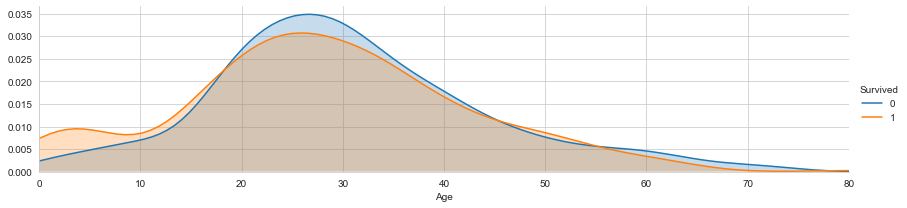

In [17]:
#不同年齡下，生存與不生存的分布
facet = sns.FacetGrid(train_data, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train_data['Age'].max()))
facet.add_legend()

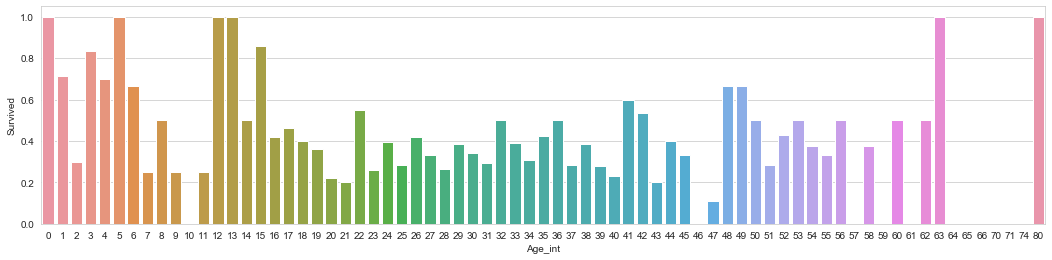

In [18]:
# average survived passengers by age
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
train_data["Age_int"] = train_data["Age"].astype(int)
average_age = train_data[["Age_int", "Survived"]].groupby(['Age_int'],as_index=False).mean()
sns.barplot(x='Age_int', y='Survived', data=average_age)

In [19]:
train_data['Age'].describe()

count    891.000000
mean      29.655290
std       13.736452
min        0.420000
25%       21.000000
50%       28.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

In [20]:
#样本有891，平均年龄约为30岁，标准差13.5岁，最小年龄为0.42，最大年龄80.

#按照年龄，将乘客划分为儿童、少年、成年和老年，分析四个群体的生还情况：
bins = [0, 12, 18, 65, 100]
train_data['Age_group'] = pd.cut(train_data['Age'], bins)
by_age = train_data.groupby('Age_group')['Survived'].mean()
by_age

Age_group
(0, 12]      0.506173
(12, 18]     0.466667
(18, 65]     0.364512
(65, 100]    0.125000
Name: Survived, dtype: float64

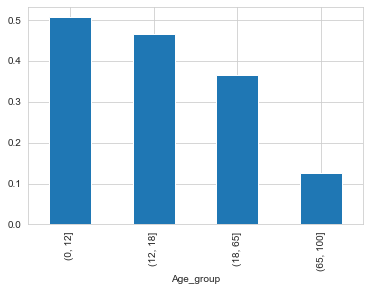

In [21]:
by_age.plot(kind = 'bar')

In [22]:
# 5. 稱呼與存活與否的關係

train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(train_data['Title'], train_data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


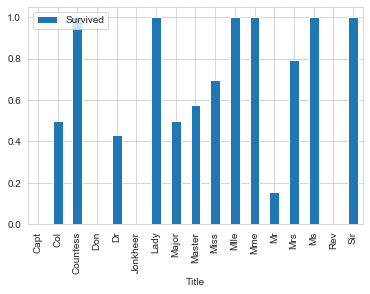

In [23]:
# 觀察稱呼與存活的關係
train_data[['Title','Survived']].groupby(['Title']).mean().plot.bar()

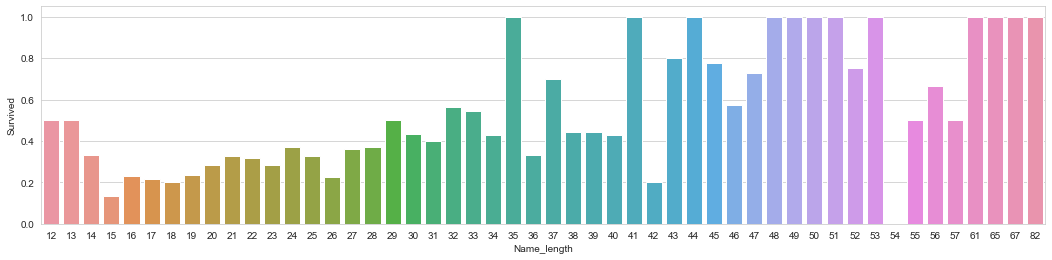

In [24]:
# 觀察名字長度與存活的關聯
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
train_data['Name_length'] = train_data['Name'].apply(len)
name_length = train_data[['Name_length','Survived']].groupby(['Name_length'],as_index=False).mean()
sns.barplot(x='Name_length', y='Survived', data=name_length)

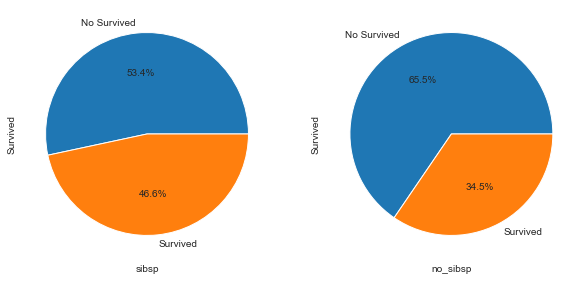

In [25]:
# 6. 有無兄弟姊妹與存活的關係

sibsp_df = train_data[train_data['SibSp'] != 0]
no_sibsp_df = train_data[train_data['SibSp'] == 0]

plt.figure(figsize=(10,5))
plt.subplot(121)
sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'], autopct = '%1.1f%%')
plt.xlabel('sibsp')

plt.subplot(122)
no_sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'], autopct = '%1.1f%%')
plt.xlabel('no_sibsp')

plt.show()

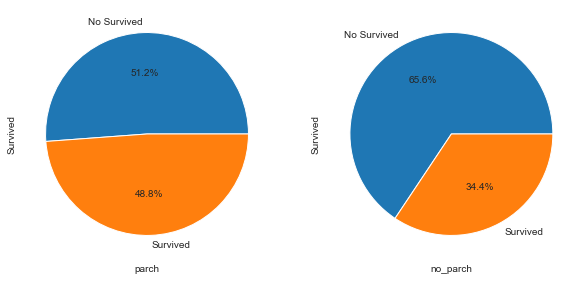

In [26]:
# 7. 有無父母/子女與存活的關聯

parch_df = train_data[train_data['Parch'] != 0]
no_parch_df = train_data[train_data['Parch'] == 0]

plt.figure(figsize=(10,5))
plt.subplot(121)
parch_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'], autopct = '%1.1f%%')
plt.xlabel('parch')

plt.subplot(122)
no_parch_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'], autopct = '%1.1f%%')
plt.xlabel('no_parch')

plt.show()

Text(0.5, 1.0, 'SibSp and Survived')

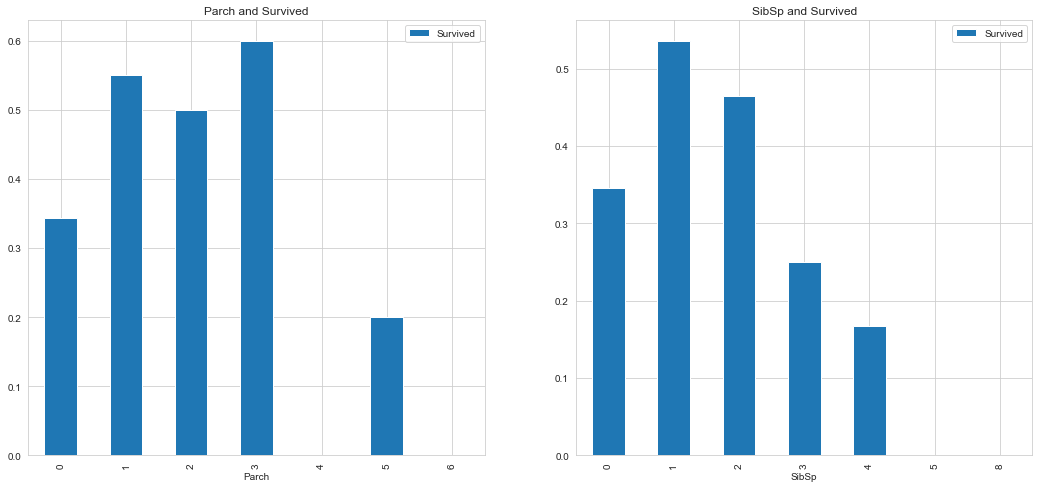

In [27]:
# 8. 同時觀察 有無兄弟姊妹、父母/子女 與存活間的關聯

fig,ax=plt.subplots(1,2,figsize=(18,8))
train_data[['Parch','Survived']].groupby(['Parch']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Parch and Survived')
train_data[['SibSp','Survived']].groupby(['SibSp']).mean().plot.bar(ax=ax[1])
ax[1].set_title('SibSp and Survived')

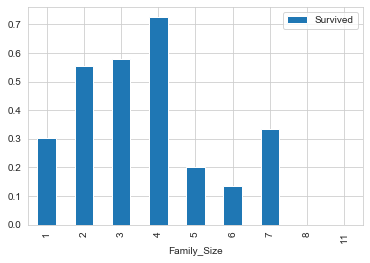

In [28]:
train_data['Family_Size'] = train_data['Parch'] + train_data['SibSp'] + 1
train_data[['Family_Size','Survived']].groupby(['Family_Size']).mean().plot.bar()
#看出親戚數量越極端，存活率較低

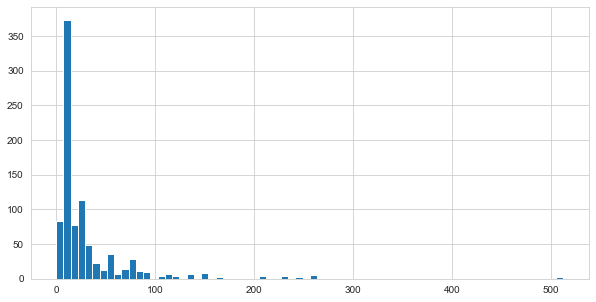

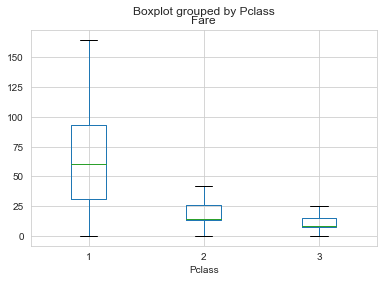

In [29]:
# 9. 票價fare與生存的關聯
# 先觀察票價分布
plt.figure(figsize=(10,5))
train_data['Fare'].hist(bins = 70)

train_data.boxplot(column='Fare', by='Pclass', showfliers=False)
plt.show()

In [30]:
train_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

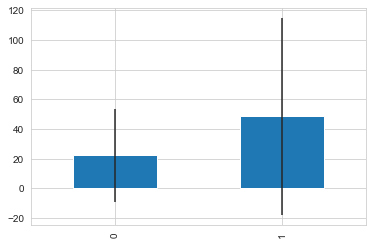

In [31]:
# 生存與否與票價均值和方差的關聯
fare_not_survived = train_data['Fare'][train_data['Survived'] == 0]
fare_survived = train_data['Fare'][train_data['Survived'] == 1]

average_fare = pd.DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare = pd.DataFrame([fare_not_survived.std(), fare_survived.std()])
average_fare.plot(yerr=std_fare, kind='bar', legend=False)

plt.show()
#生存者的票價均值較高

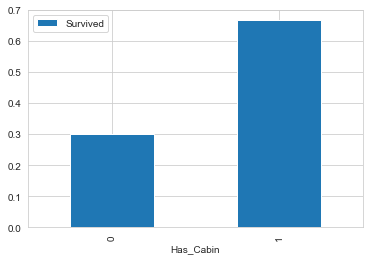

In [32]:
# 10. 艙等Cabin與生存的關聯
# 艙等缺失值太多，直接用艙等有紀錄&艙等無紀錄做分類
# Replace missing values with "U0"
train_data.loc[train_data.Cabin.isnull(), 'Cabin'] = 'U0'
train_data['Has_Cabin'] = train_data['Cabin'].apply(lambda x: 0 if x == 'U0' else 1)
train_data[['Has_Cabin','Survived']].groupby(['Has_Cabin']).mean().plot.bar()

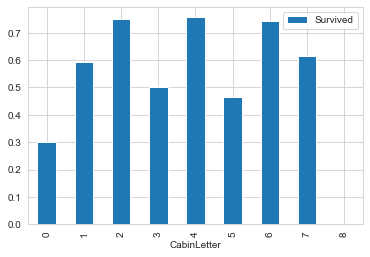

In [33]:
# create feature for the alphabetical part of the cabin number
train_data['CabinLetter'] = train_data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
# convert the distinct cabin letters with incremental integer values
train_data['CabinLetter'] = pd.factorize(train_data['CabinLetter'])[0]
train_data[['CabinLetter','Survived']].groupby(['CabinLetter']).mean().plot.bar()
#觀察圖表，艙等與生存率無直接關係，缺失值又多，後面不分析艙等

Text(0.5, 1.0, 'Embarked and Survived')

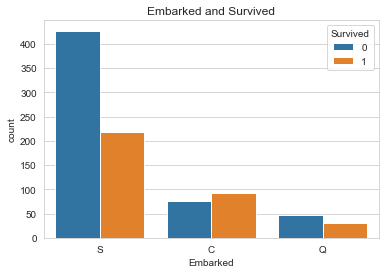

In [34]:
# 11. 港口與生存與否的關係
sns.countplot('Embarked', hue='Survived', data=train_data)
plt.title('Embarked and Survived')

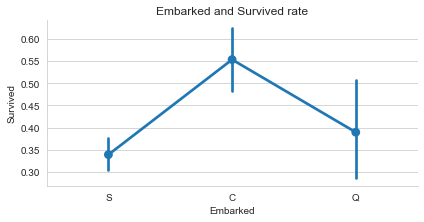

In [36]:
sns.factorplot('Embarked', 'Survived', data=train_data, size=3, aspect=2)
plt.title('Embarked and Survived rate')
plt.show()
#生存率：C港口最高，Q港口次之，S港口最低，可能跟S港口都買低價票有關。

In [37]:
#用 Dummy Variables 處理離散式的類別變量Embarked
embark_dummies  = pd.get_dummies(train_data['Embarked'])
train_data = train_data.join(embark_dummies)
train_data.drop(['Embarked'], axis=1,inplace=True)

embark_dummies = train_data[['S', 'C', 'Q']]
embark_dummies.head()

,S,C,Q
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


In [38]:
# 用 factorized 處理Cabin
#dummy不好处理Cabin（船舱号）这种标称属性，因为他出现的变量比较多。所以Pandas有一个方法叫做factorize()，
#它可以创建一些数字，来表示类别变量，对每一个类别映射一个ID，这种映射最后只生成一个特征，不像dummy那样生成多个特征。
# Replace missing values with "U0"
train_data['Cabin'][train_data.Cabin.isnull()] = 'U0'
# create feature for the alphabetical part of the cabin number
train_data['CabinLetter'] = train_data['Cabin'].map( lambda x : re.compile("([a-zA-Z]+)").search(x).group())
# convert the distinct cabin letters with incremental integer values
train_data['CabinLetter'] = pd.factorize(train_data['CabinLetter'])[0]

train_data['CabinLetter'].head()

0    0
1    1
2    0
3    1
4    0
Name: CabinLetter, dtype: int64

In [39]:
# 對 age做scaling
from sklearn import preprocessing

assert np.size(train_data['Age']) == 891
# StandardScaler will subtract the mean from each value then scale to the unit variance
scaler = preprocessing.StandardScaler()
train_data['Age_scaled'] = scaler.fit_transform(train_data['Age'].values.reshape(-1, 1))

train_data['Age_scaled'].head()

0   -0.557610
1    0.607828
2   -0.266251
3    0.389308
4    0.389308
Name: Age_scaled, dtype: float64

In [40]:
#Binning通过观察“邻居”(即周围的值)将连续数据离散化。存储的值被分布到一些“桶”或“箱“”中，就像直方图的bin将数据划分成几块一样。
#下面的代码对Fare进行Binning。

# Divide all fares into quartiles
train_data['Fare_bin'] = pd.qcut(train_data['Fare'], 5)
train_data['Fare_bin'].head()

0      (-0.001, 7.854]
1    (39.688, 512.329]
2        (7.854, 10.5]
3    (39.688, 512.329]
4        (7.854, 10.5]
Name: Fare_bin, dtype: category
Categories (5, interval[float64]): [(-0.001, 7.854] < (7.854, 10.5] < (10.5, 21.679] < (21.679, 39.688] < (39.688, 512.329]]

In [41]:
#在将数据Bining化后，要么将数据factorize化，要么dummies化。

# qcut() creates a new variable that identifies the quartile range, but we can't use the string
# so either factorize or create dummies from the result

# factorize
train_data['Fare_bin_id'] = pd.factorize(train_data['Fare_bin'])[0]

# dummies
fare_bin_dummies_df = pd.get_dummies(train_data['Fare_bin']).rename(columns=lambda x: 'Fare_' + str(x))
train_data = pd.concat([train_data, fare_bin_dummies_df], axis=1)

In [42]:
# 特徵工程
#在进行特征工程的时候，我们不仅需要对训练数据进行处理，还需要同时将测试数据同训练数据一起处理，使得二者具有相同的数据类型和数据分布。

train_df_org = pd.read_csv('C:\Anaconda2\Titanic-KaggleTest//train.csv')
test_df_org = pd.read_csv('C:\Anaconda2\Titanic-KaggleTest//test.csv')
test_df_org['Survived'] = 0
combined_train_test = train_df_org.append(test_df_org)
PassengerId = test_df_org['PassengerId']





In [43]:
# 以眾數補充Embarked
combined_train_test['Embarked'].fillna(combined_train_test['Embarked'].mode().iloc[0], inplace=True)

In [44]:
# 用Dummy處理港口
# 为了后面的特征分析，这里我们将 Embarked 特征进行facrorizing
combined_train_test['Embarked'] = pd.factorize(combined_train_test['Embarked'])[0]

# 使用 pd.get_dummies 获取one-hot 编码
emb_dummies_df = pd.get_dummies(combined_train_test['Embarked'], prefix=combined_train_test[['Embarked']].columns[0])
combined_train_test = pd.concat([combined_train_test, emb_dummies_df], axis=1)


In [45]:
# 对Sex也进行one-hot编码，也就是dummy处理：
# 为了后面的特征分析，这里我们也将 Sex 特征进行facrorizing
combined_train_test['Sex'] = pd.factorize(combined_train_test['Sex'])[0]

sex_dummies_df = pd.get_dummies(combined_train_test['Sex'], prefix=combined_train_test[['Sex']].columns[0])
combined_train_test = pd.concat([combined_train_test, sex_dummies_df], axis=1)

In [46]:
# what is each person's title? 
combined_train_test['Title'] = combined_train_test['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])

In [47]:
# 稱呼統一化
title_Dict = {}
title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))

combined_train_test['Title'] = combined_train_test['Title'].map(title_Dict)

In [48]:
#使用Dummy對稱呼分列
# 为了后面的特征分析，这里我们也将 Title 特征进行facrorizing
combined_train_test['Title'] = pd.factorize(combined_train_test['Title'])[0]

title_dummies_df = pd.get_dummies(combined_train_test['Title'], prefix=combined_train_test[['Title']].columns[0])
combined_train_test = pd.concat([combined_train_test, title_dummies_df], axis=1)

In [57]:
# 增加名字長度
combined_train_test['Name_length'] = combined_train_test['Name'].apply(len)

In [58]:
#fare缺失值補充，用123等艙的均價
combined_train_test['Fare'] = combined_train_test[['Fare']].fillna(combined_train_test.groupby('Pclass').transform(np.mean))

#將團體票的票價分到每個人頭上
combined_train_test['Group_Ticket'] = combined_train_test['Fare'].groupby(by=combined_train_test['Ticket']).transform('count')
combined_train_test['Fare'] = combined_train_test['Fare'] / combined_train_test['Group_Ticket']
combined_train_test.drop(['Group_Ticket'], axis=1, inplace=True)

#用binning給票價分等級
combined_train_test['Fare_bin'] = pd.qcut(combined_train_test['Fare'], 5)

#用dummy為五個等級的票價等級分列
combined_train_test['Fare_bin_id'] = pd.factorize(combined_train_test['Fare_bin'])[0]

fare_bin_dummies_df = pd.get_dummies(combined_train_test['Fare_bin_id']).rename(columns=lambda x: 'Fare_' + str(x))
combined_train_test = pd.concat([combined_train_test, fare_bin_dummies_df], axis=1)
combined_train_test.drop(['Fare_bin'], axis=1, inplace=True)

In [59]:
#將Pclass轉換成Dummy形式，並分出每等艙裡的高價與低價
from sklearn.preprocessing import LabelEncoder

# 建立PClass Fare Category
def pclass_fare_category(df, pclass1_mean_fare, pclass2_mean_fare, pclass3_mean_fare):
    if df['Pclass'] == 1:
        if df['Fare'] <= pclass1_mean_fare:
            return 'Pclass1_Low'
        else:
            return 'Pclass1_High'
    elif df['Pclass'] == 2:
        if df['Fare'] <= pclass2_mean_fare:
            return 'Pclass2_Low'
        else:
            return 'Pclass2_High'
    elif df['Pclass'] == 3:
        if df['Fare'] <= pclass3_mean_fare:
            return 'Pclass3_Low'
        else:
            return 'Pclass3_High'

Pclass1_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([1]).values[0]
Pclass2_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([2]).values[0]
Pclass3_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([3]).values[0]

# 建立Pclass_Fare Category
combined_train_test['Pclass_Fare_Category'] = combined_train_test.apply(pclass_fare_category, args=(
 Pclass1_mean_fare, Pclass2_mean_fare, Pclass3_mean_fare), axis=1)
pclass_level = LabelEncoder()

# 给每一项添加标签
pclass_level.fit(np.array(
 ['Pclass1_Low', 'Pclass1_High', 'Pclass2_Low', 'Pclass2_High', 'Pclass3_Low', 'Pclass3_High']))

# 转换成数值
combined_train_test['Pclass_Fare_Category'] = pclass_level.transform(combined_train_test['Pclass_Fare_Category'])

# dummy 转换
pclass_dummies_df = pd.get_dummies(combined_train_test['Pclass_Fare_Category']).rename(columns=lambda x: 'Pclass_' + str(x))
combined_train_test = pd.concat([combined_train_test, pclass_dummies_df], axis=1)

#將Pclass特徵factorize化
combined_train_test['Pclass'] = pd.factorize(combined_train_test['Pclass'])[0]

AttributeError: 'NoneType' object has no attribute 'values'

In [60]:
#將parch,sibsp合併成family一項，因為與生存的直接關聯較低
def family_size_category(family_size):
    if family_size <= 1:
        return 'Single'
    elif family_size <= 4:
        return 'Small_Family'
    else:
        return 'Large_Family'

combined_train_test['Family_Size'] = combined_train_test['Parch'] + combined_train_test['SibSp'] + 1
combined_train_test['Family_Size_Category'] = combined_train_test['Family_Size'].map(family_size_category)

le_family = LabelEncoder()
le_family.fit(np.array(['Single', 'Small_Family', 'Large_Family']))
combined_train_test['Family_Size_Category'] = le_family.transform(combined_train_test['Family_Size_Category'])

family_size_dummies_df = pd.get_dummies(combined_train_test['Family_Size_Category'],
                                     prefix=combined_train_test[['Family_Size_Category']].columns[0])
combined_train_test = pd.concat([combined_train_test, family_size_dummies_df], axis=1)


In [56]:
#因为Age项的缺失值较多，所以不能直接填充age的众数或者平均数。
#常见的有两种对年龄的填充方式：一种是根据Title中的称呼，如Mr，Master、Miss等称呼不同类别的人的平均年龄来填充；
#一种是综合几项如Sex、Title、Pclass等其他没有缺失值的项，使用机器学习算法来预测Age。
#这里使用后者来处理。以Age为目标值，将Age完整的项作为训练集，将Age缺失的项作为测试集。

missing_age_df = pd.DataFrame(combined_train_test[
 ['Age', 'Embarked', 'Sex', 'Title', 'Name_length', 'Family_Size', 'Family_Size_Category','Fare', 'Fare_bin_id', 'Pclass']])

missing_age_train = missing_age_df[missing_age_df['Age'].notnull()]
missing_age_test = missing_age_df[missing_age_df['Age'].isnull()]



KeyError: "['Name_length'] not in index"